# 02 - Rollout with Baseline Policy

This notebook demonstrates a complete season simulation with the hand-coded baseline policy.

We'll visualize:
1. Environmental stress signals over time
2. Tree state evolution (biomass in each compartment)
3. Resource allocation decisions
4. Policy comparison across different climates

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from sim import ClimateConfig, SimConfig, run_season
from sim import policies, stress

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Environmental Stress Signals

First, let's visualize the sinusoidal stress signals for different climates.

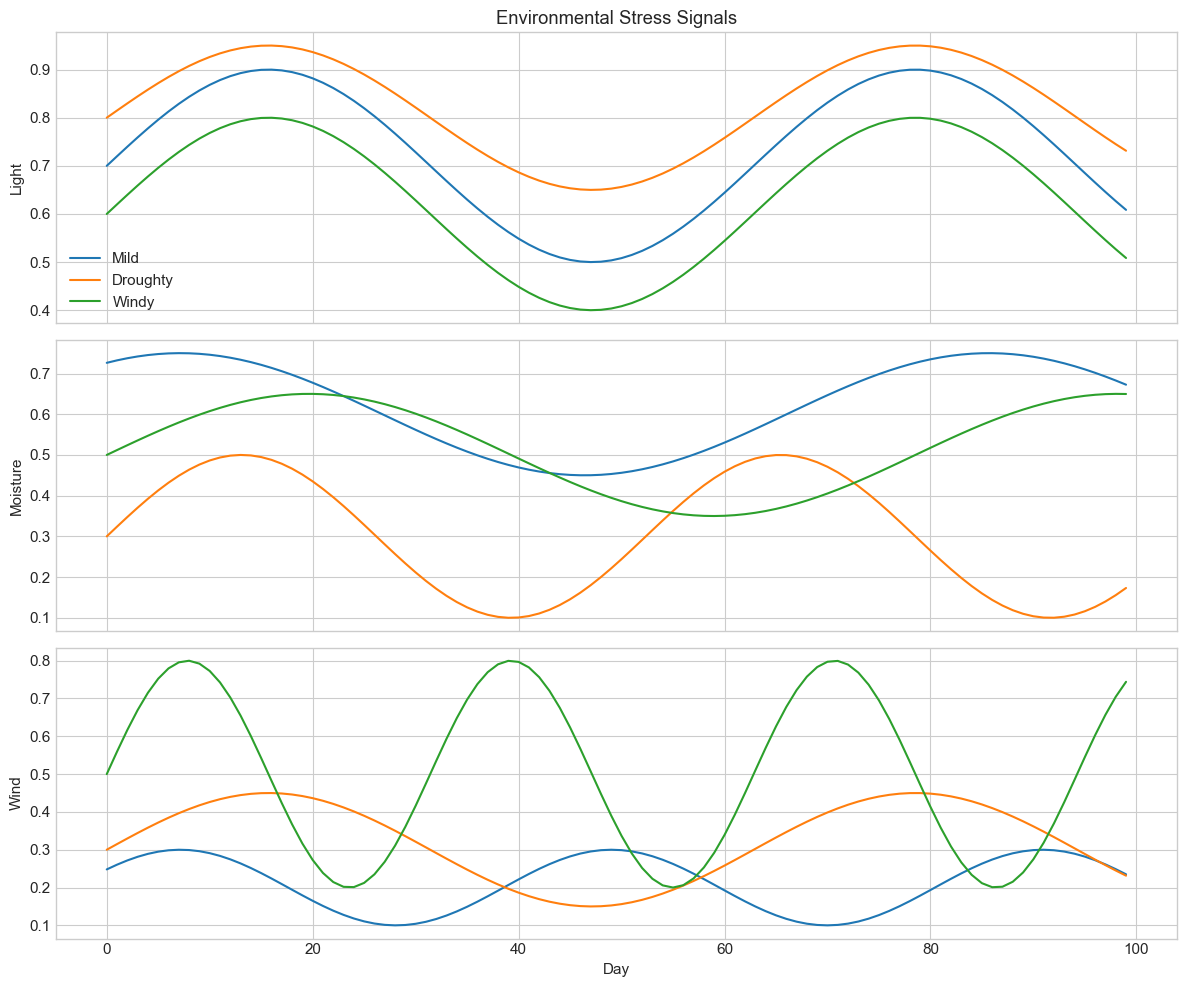

In [2]:
num_days = 100
days = np.arange(num_days)

climates = {
    'Mild': ClimateConfig.mild(),
    'Droughty': ClimateConfig.droughty(),
    'Windy': ClimateConfig.windy(),
}

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

for name, climate in climates.items():
    light, moisture, wind = stress.compute_environment_batch(climate, num_days)
    
    axes[0].plot(days, light, label=name)
    axes[1].plot(days, moisture, label=name)
    axes[2].plot(days, wind, label=name)

axes[0].set_ylabel('Light')
axes[0].set_title('Environmental Stress Signals')
axes[0].legend()

axes[1].set_ylabel('Moisture')

axes[2].set_ylabel('Wind')
axes[2].set_xlabel('Day')

plt.tight_layout()
plt.show()

## 2. Single Season Rollout

Run a complete season with the baseline policy in a mild climate.

In [3]:
config = SimConfig(num_days=100)
climate = ClimateConfig.mild()

trajectory = run_season(
    config=config,
    climate=climate,
    policy=policies.baseline_policy,
)

print(f"Final seeds produced: {float(trajectory.seeds):.2f}")
print(f"Final biomass: {float(trajectory.states[-1].total_biomass()):.2f}")

Final seeds produced: 1.80
Final biomass: 5.05


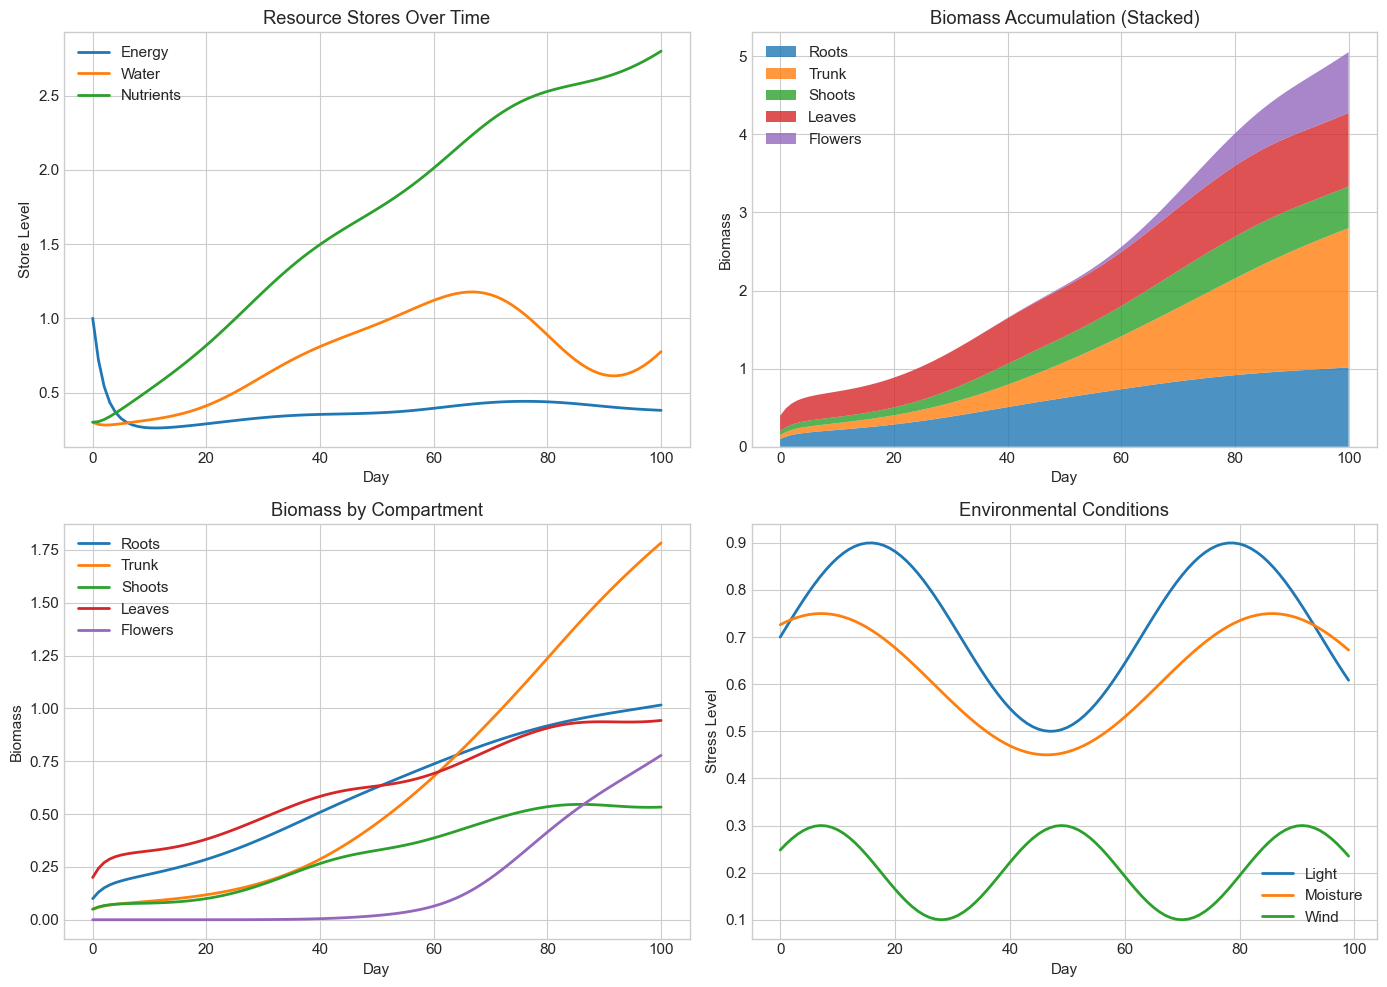

In [4]:
# Get state arrays for plotting
states = trajectory.get_state_arrays()
days = np.arange(len(trajectory.states))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Stores (Energy, Water, Nutrients)
ax = axes[0, 0]
ax.plot(days, states['energy'], label='Energy', linewidth=2)
ax.plot(days, states['water'], label='Water', linewidth=2)
ax.plot(days, states['nutrients'], label='Nutrients', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Store Level')
ax.set_title('Resource Stores Over Time')
ax.legend()

# Plot 2: Biomass compartments
ax = axes[0, 1]
ax.stackplot(days,
    states['roots'],
    states['trunk'],
    states['shoots'],
    states['leaves'],
    states['flowers'],
    labels=['Roots', 'Trunk', 'Shoots', 'Leaves', 'Flowers'],
    alpha=0.8
)
ax.set_xlabel('Day')
ax.set_ylabel('Biomass')
ax.set_title('Biomass Accumulation (Stacked)')
ax.legend(loc='upper left')

# Plot 3: Individual biomass lines
ax = axes[1, 0]
ax.plot(days, states['roots'], label='Roots', linewidth=2)
ax.plot(days, states['trunk'], label='Trunk', linewidth=2)
ax.plot(days, states['shoots'], label='Shoots', linewidth=2)
ax.plot(days, states['leaves'], label='Leaves', linewidth=2)
ax.plot(days, states['flowers'], label='Flowers', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Biomass')
ax.set_title('Biomass by Compartment')
ax.legend()

# Plot 4: Stress signals
ax = axes[1, 1]
stress_days = np.arange(len(trajectory.light_history))
ax.plot(stress_days, trajectory.light_history, label='Light', linewidth=2)
ax.plot(stress_days, trajectory.moisture_history, label='Moisture', linewidth=2)
ax.plot(stress_days, trajectory.wind_history, label='Wind', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Stress Level')
ax.set_title('Environmental Conditions')
ax.legend()

plt.tight_layout()
plt.show()

## 3. Allocation Strategy Over Time

Visualize how the baseline policy allocates resources throughout the season.

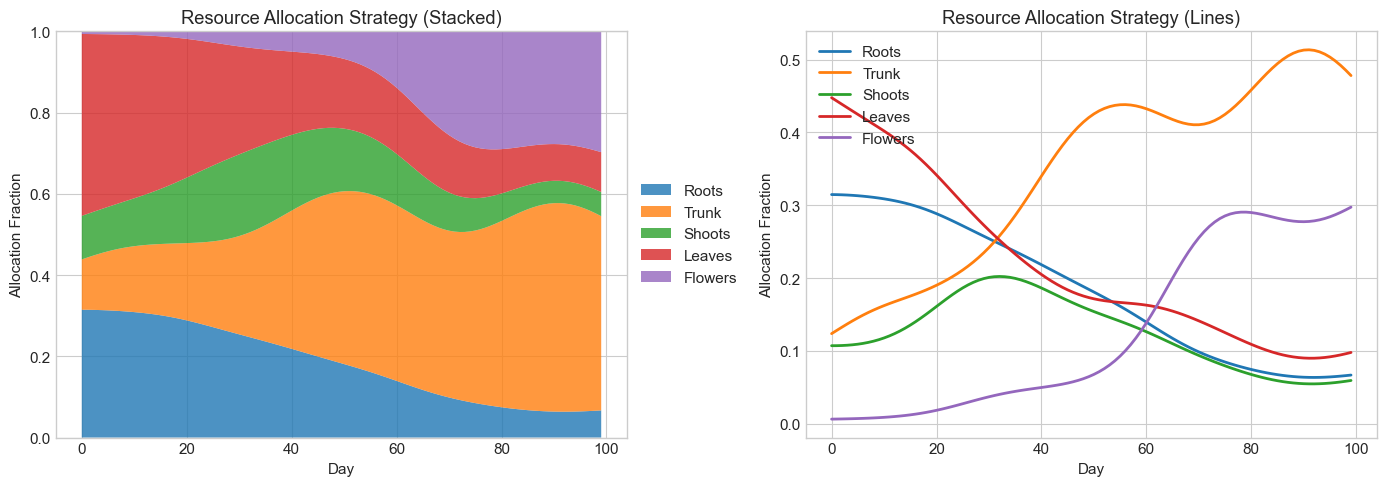

In [5]:
allocations = trajectory.get_allocation_arrays()
alloc_days = np.arange(len(trajectory.allocations))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stacked area plot
ax1.stackplot(alloc_days,
    allocations['roots'],
    allocations['trunk'],
    allocations['shoots'],
    allocations['leaves'],
    allocations['flowers'],
    labels=['Roots', 'Trunk', 'Shoots', 'Leaves', 'Flowers'],
    alpha=0.8
)
ax1.set_xlabel('Day')
ax1.set_ylabel('Allocation Fraction')
ax1.set_title('Resource Allocation Strategy (Stacked)')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.set_ylim(0, 1)

# Line plot
ax2.plot(alloc_days, allocations['roots'], label='Roots', linewidth=2)
ax2.plot(alloc_days, allocations['trunk'], label='Trunk', linewidth=2)
ax2.plot(alloc_days, allocations['shoots'], label='Shoots', linewidth=2)
ax2.plot(alloc_days, allocations['leaves'], label='Leaves', linewidth=2)
ax2.plot(alloc_days, allocations['flowers'], label='Flowers', linewidth=2)
ax2.set_xlabel('Day')
ax2.set_ylabel('Allocation Fraction')
ax2.set_title('Resource Allocation Strategy (Lines)')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. Policy Comparison

Compare different policies in the same climate.

In [6]:
from sim.rollout import compare_policies

policy_dict = {
    'Baseline': policies.baseline_policy,
    'Growth-focused': policies.growth_focused_policy,
    'Defensive': policies.defensive_policy,
    'Reproduction': policies.reproduction_policy,
}

results = compare_policies(policy_dict, config, ClimateConfig.mild())

print("\nPolicy Comparison (Mild Climate):")
print("-" * 50)
for name, metrics in results.items():
    print(f"{name:20} Seeds: {metrics['mean_seeds']:8.2f}  Biomass: {metrics['mean_biomass']:8.2f}")


Policy Comparison (Mild Climate):
--------------------------------------------------
Baseline             Seeds:     1.80  Biomass:     5.05
Growth-focused       Seeds:     0.03  Biomass:     2.97
Defensive            Seeds:     0.22  Biomass:     3.21
Reproduction         Seeds:     0.41  Biomass:     2.55


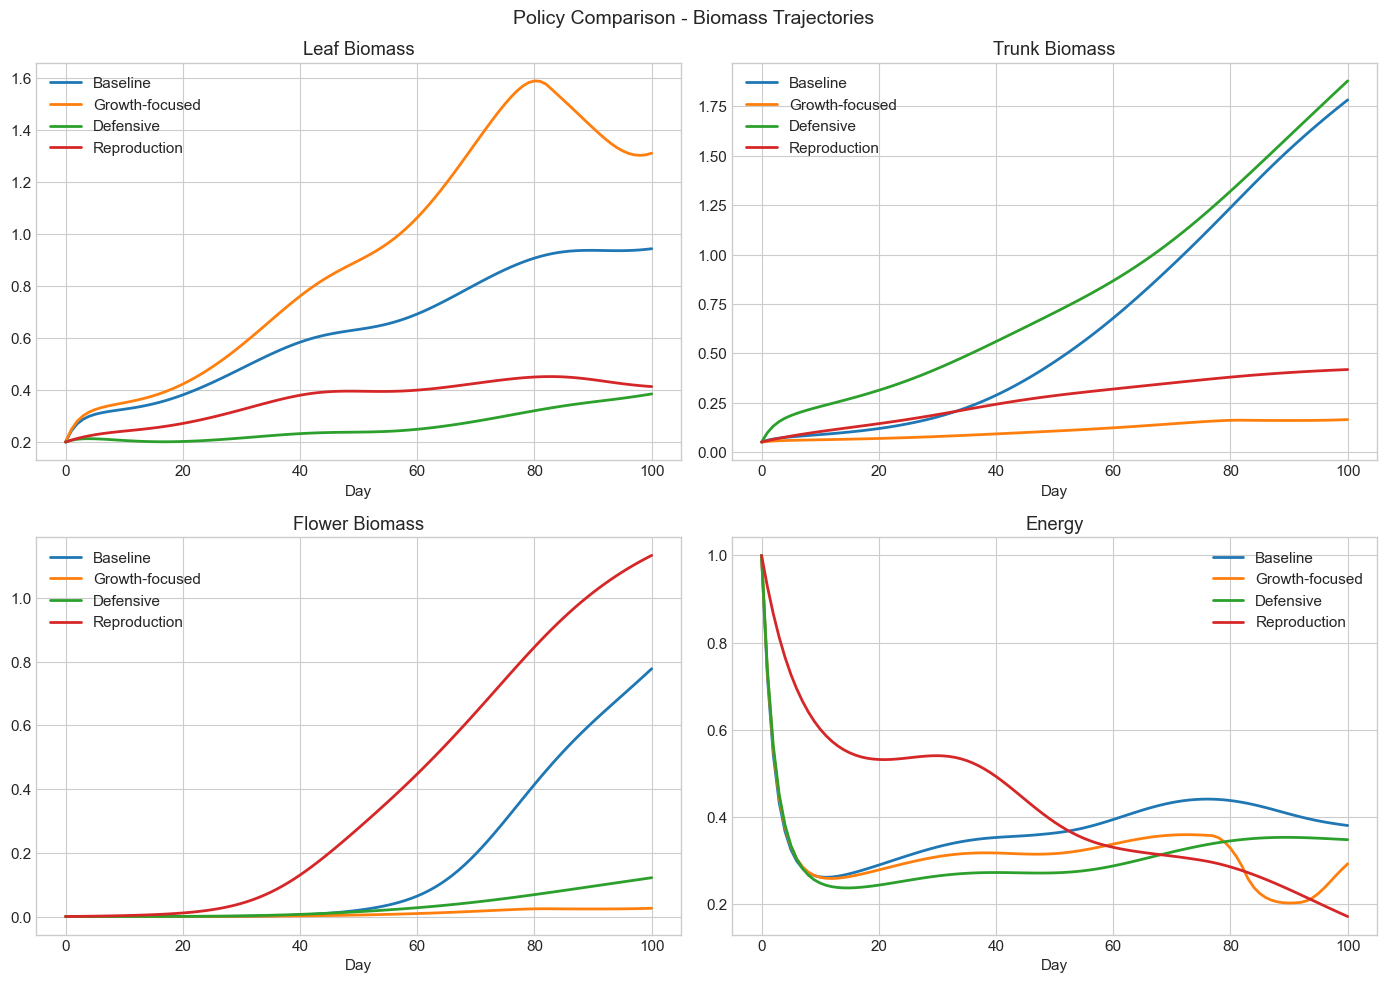

In [7]:
# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for name, policy in policy_dict.items():
    traj = run_season(config, ClimateConfig.mild(), policy)
    states = traj.get_state_arrays()
    days = np.arange(len(traj.states))
    
    axes[0, 0].plot(days, states['leaves'], label=name, linewidth=2)
    axes[0, 1].plot(days, states['trunk'], label=name, linewidth=2)
    axes[1, 0].plot(days, states['flowers'], label=name, linewidth=2)
    axes[1, 1].plot(days, states['energy'], label=name, linewidth=2)

axes[0, 0].set_title('Leaf Biomass')
axes[0, 0].set_xlabel('Day')
axes[0, 0].legend()

axes[0, 1].set_title('Trunk Biomass')
axes[0, 1].set_xlabel('Day')
axes[0, 1].legend()

axes[1, 0].set_title('Flower Biomass')
axes[1, 0].set_xlabel('Day')
axes[1, 0].legend()

axes[1, 1].set_title('Energy')
axes[1, 1].set_xlabel('Day')
axes[1, 1].legend()

plt.suptitle('Policy Comparison - Biomass Trajectories', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Climate Comparison

Run the baseline policy across different climates.

In [8]:
climate_results = {}
for name, climate in climates.items():
    traj = run_season(config, climate, policies.baseline_policy)
    climate_results[name] = {
        'trajectory': traj,
        'seeds': float(traj.seeds),
        'final_biomass': float(traj.states[-1].total_biomass()),
    }

print("\nBaseline Policy Across Climates:")
print("-" * 50)
for name, data in climate_results.items():
    print(f"{name:15} Seeds: {data['seeds']:8.2f}  Final Biomass: {data['final_biomass']:8.2f}")


Baseline Policy Across Climates:
--------------------------------------------------
Mild            Seeds:     1.80  Final Biomass:     5.05
Droughty        Seeds:     0.06  Final Biomass:     1.52
Windy           Seeds:     0.01  Final Biomass:     1.10


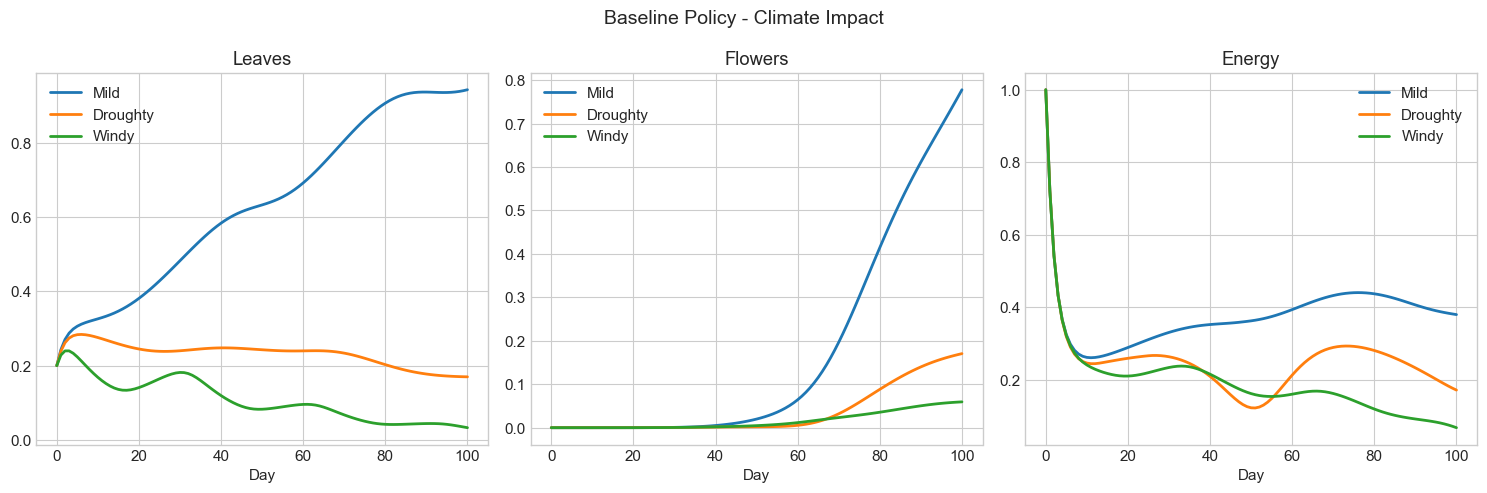

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for name, data in climate_results.items():
    states = data['trajectory'].get_state_arrays()
    days = np.arange(len(data['trajectory'].states))
    
    axes[0].plot(days, states['leaves'], label=name, linewidth=2)
    axes[1].plot(days, states['flowers'], label=name, linewidth=2)
    axes[2].plot(days, states['energy'], label=name, linewidth=2)

axes[0].set_title('Leaves')
axes[0].set_xlabel('Day')
axes[0].legend()

axes[1].set_title('Flowers')
axes[1].set_xlabel('Day')
axes[1].legend()

axes[2].set_title('Energy')
axes[2].set_xlabel('Day')
axes[2].legend()

plt.suptitle('Baseline Policy - Climate Impact', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Energy Budget Diagnostic

To understand **why** harsh climates produce stunted trees, we need to examine the energy and water budgets.

In [10]:
from sim.dynamics import diagnose_energy_budget

def analyze_energy_budget(name, climate, config):
    """Analyze energy and water flows over a season."""
    from sim.config import TreeState
    from sim.dynamics import step
    
    state = TreeState.initial(energy=1.0)
    
    photo_hist, maint_hist = [], []
    water_hist, water_uptake_hist, transpiration_hist = [], [], []
    leaves_hist = []
    
    for day in range(config.num_days):
        light, moisture, wind = stress.compute_environment(climate, day)
        allocation = policies.baseline_policy(state, day, config.num_days)
        
        diag = diagnose_energy_budget(state, allocation, float(light), float(moisture), float(wind), config)
        
        photo_hist.append(diag['photosynthesis'])
        maint_hist.append(diag['maintenance'])
        water_hist.append(float(state.water))
        water_uptake_hist.append(diag['water_uptake'])
        transpiration_hist.append(config.transpiration_rate * float(state.leaves) * float(light))
        leaves_hist.append(float(state.leaves))
        
        state = step(state, allocation, float(light), float(moisture), float(wind), config)
    
    return {
        'photo': photo_hist,
        'maint': maint_hist,
        'water': water_hist,
        'water_uptake': water_uptake_hist,
        'transpiration': transpiration_hist,
        'leaves': leaves_hist,
    }

# Analyze all climates
budget_data = {}
for name, climate in climates.items():
    budget_data[name] = analyze_energy_budget(name, climate, config)

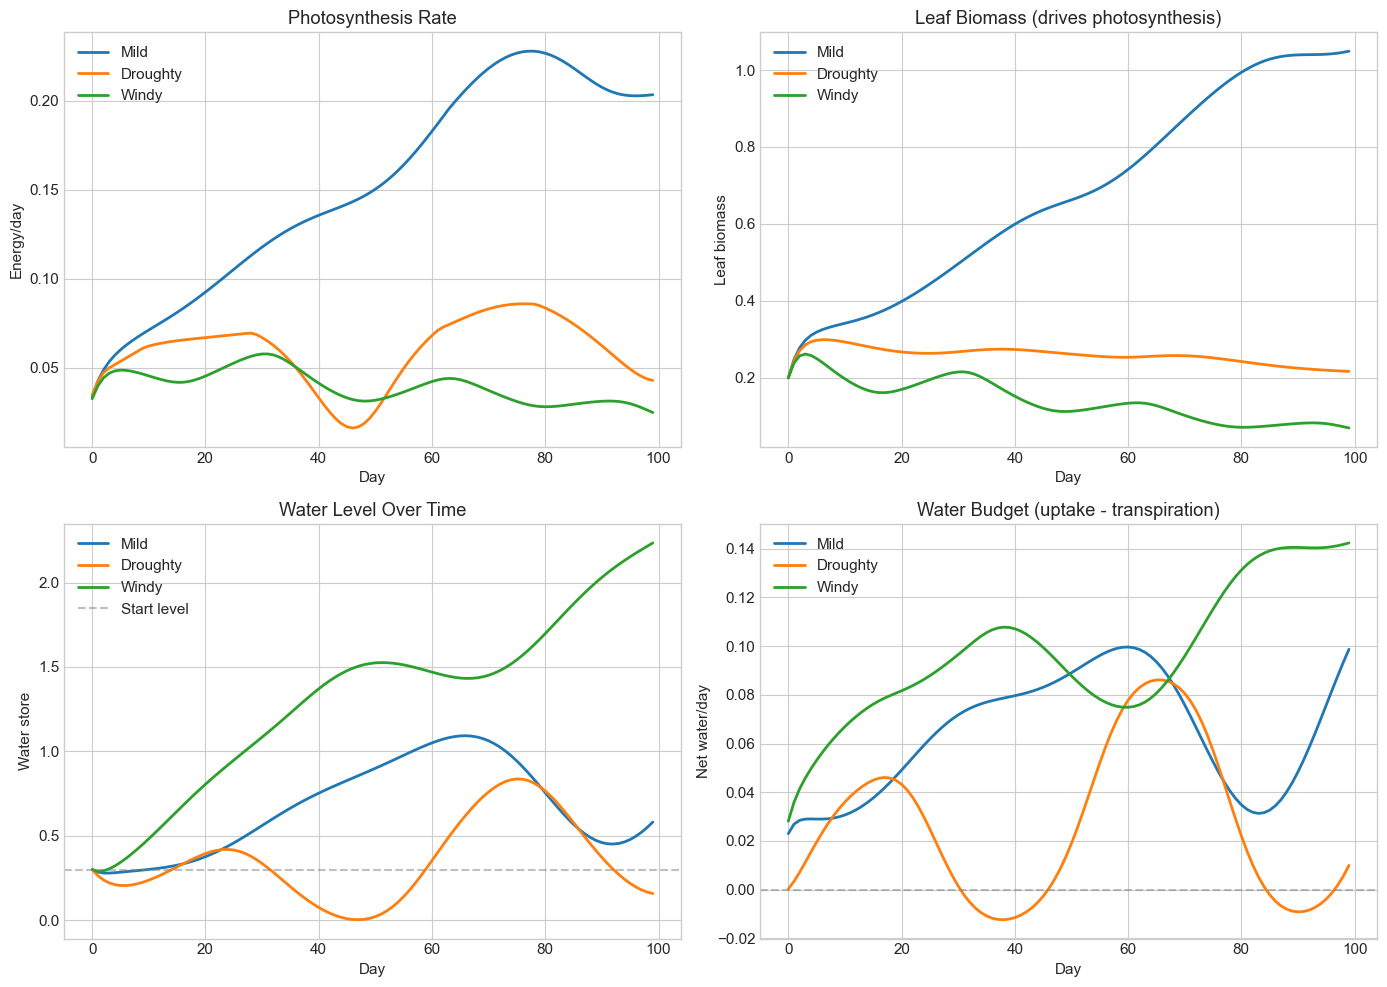

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
days = np.arange(config.num_days)

# Energy budget
ax = axes[0, 0]
for name, data in budget_data.items():
    ax.plot(days, data['photo'], label=f'{name}', linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Energy/day')
ax.set_title('Photosynthesis Rate')
ax.legend()

# Leaves (explains why photosynthesis differs)
ax = axes[0, 1]
for name, data in budget_data.items():
    ax.plot(days, data['leaves'], label=name, linewidth=2)
ax.set_xlabel('Day')
ax.set_ylabel('Leaf biomass')
ax.set_title('Leaf Biomass (drives photosynthesis)')
ax.legend()

# Water levels
ax = axes[1, 0]
for name, data in budget_data.items():
    ax.plot(days, data['water'], label=name, linewidth=2)
ax.axhline(y=0.3, color='gray', linestyle='--', alpha=0.5, label='Start level')
ax.set_xlabel('Day')
ax.set_ylabel('Water store')
ax.set_title('Water Level Over Time')
ax.legend()

# Net water budget
ax = axes[1, 1]
for name, data in budget_data.items():
    net_water = [u - t for u, t in zip(data['water_uptake'], data['transpiration'])]
    ax.plot(days, net_water, label=name, linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Day')
ax.set_ylabel('Net water/day')
ax.set_title('Water Budget (uptake - transpiration)')
ax.legend()

plt.tight_layout()
plt.show()

### Key Insight: Energy-Limited, Not Water-Limited

The diagnostic reveals a **counterintuitive dynamic**:

**In harsh climates, water actually ACCUMULATES rather than becoming scarce.**

Here's why:

1. **Droughty climate**: Low moisture reduces photosynthesis efficiency (Michaelis-Menten saturation). With less energy, the tree can't grow leaves. Fewer leaves = less transpiration = water piles up.

2. **Windy climate**: Wind damage kills leaves directly (capped at 5%/day). Dead leaves don't transpire, so water accumulates even faster.

**The failure mode is energy-limited, not water-limited:**
- Trees don't die from water shortage
- They die from inability to photosynthesize enough to grow/maintain leaves
- This creates a death spiral: fewer leaves → less photosynthesis → less growth → fewer leaves

**Implication for learned policies:**
A smart policy might try to "invest in roots during drought" but the current dynamics don't reward that directly—the bottleneck is photosynthesis efficiency, not water availability. The gradient signal for "roots help in drought" is weak.

**Possible future improvements:**
- Increase transpiration rate so water becomes scarce before leaves die
- Make photosynthesis more sensitive to water availability  
- Add explicit water stress that damages leaves when water is low

## Summary So Far

This notebook demonstrated:

1. **Environmental stress signals**: Sinusoidal patterns for light, moisture, and wind
2. **Season rollout**: Complete simulation with state tracking
3. **Allocation visualization**: How the baseline policy shifts strategy over time
4. **Policy comparison**: Different strategies produce different outcomes
5. **Climate impact**: Environmental conditions affect growth and reproduction
6. **Energy budget diagnostic**: Understanding *why* harsh climates fail

### Key Observations

- The baseline policy follows PvZ economics: roots/leaves early, trunk mid, flowers late
- Harsh climates (wind, drought) reduce seed production significantly
- **Failure mechanism**: Energy-limited death spiral, not water scarcity
- The simulation is differentiable and ready for gradient-based optimization

## 7. Scalar Diagnostic Summary

The `Trajectory.get_scalar_summary()` method provides a quick overview of simulation results.

In [12]:
# Display scalar summary for mild climate run
traj_mild = run_season(config, ClimateConfig.mild(), policies.baseline_policy)
summary = traj_mild.get_scalar_summary()

print("=" * 50)
print("SIMULATION SUMMARY (Mild Climate)")
print("=" * 50)
for key, value in summary.items():
    if key == "DaysAtZero":
        print(f"{key:20s}: {int(value):>10d}")
    else:
        print(f"{key:20s}: {value:>10.3f}")
print("=" * 50)

SIMULATION SUMMARY (Mild Climate)
Seeds               :      1.800
FinalBiomass        :      5.054
FinalEnergy         :      0.380
PeakEnergy          :      1.000
MinEnergy           :      0.261
DaysAtZero          :          0
FinalTrunk          :      1.783
FinalFlowers        :      0.778
FinalRoots          :      1.016
FinalLeaves         :      0.943
MeanLight           :      0.737
MeanMoisture        :      0.628
MeanWind            :      0.212


## 8. Stress Sweep Analysis

To understand how environmental stress affects fitness (seed production), we systematically vary stress parameters and measure outcomes. This reveals the "fitness landscape" - regions where small parameter changes produce gradient signal for optimization.

In [13]:
from sim.config import StressParams

def sweep_moisture(moisture_offsets: list[float], config: SimConfig) -> dict:
    """Sweep moisture offset and measure outcomes."""
    results = {'moisture': [], 'seeds': [], 'biomass': [], 'energy': []}
    base = ClimateConfig.mild()
    
    for offset in moisture_offsets:
        climate = ClimateConfig(
            light=base.light,
            moisture=StressParams(offset=offset, amplitude=0.15, frequency=0.08, phase=1.0),
            wind=base.wind,
        )
        traj = run_season(config, climate, policies.baseline_policy)
        results['moisture'].append(offset)
        results['seeds'].append(float(traj.seeds))
        results['biomass'].append(float(traj.states[-1].total_biomass()))
        results['energy'].append(float(traj.states[-1].energy))
    return results

def sweep_wind(wind_offsets: list[float], config: SimConfig) -> dict:
    """Sweep wind offset and measure outcomes."""
    results = {'wind': [], 'seeds': [], 'biomass': [], 'energy': []}
    base = ClimateConfig.mild()
    
    for offset in wind_offsets:
        climate = ClimateConfig(
            light=base.light,
            moisture=base.moisture,
            wind=StressParams(offset=offset, amplitude=0.1, frequency=0.15, phase=0.5),
        )
        traj = run_season(config, climate, policies.baseline_policy)
        results['wind'].append(offset)
        results['seeds'].append(float(traj.seeds))
        results['biomass'].append(float(traj.states[-1].total_biomass()))
        results['energy'].append(float(traj.states[-1].energy))
    return results

# Run sweeps
moisture_offsets = np.linspace(0.2, 0.9, 15)
wind_offsets = np.linspace(0.1, 0.7, 15)

print("Running moisture sweep...")
moisture_results = sweep_moisture(list(moisture_offsets), config)
print("Running wind sweep...")
wind_results = sweep_wind(list(wind_offsets), config)
print("Done!")

Running moisture sweep...
Running wind sweep...
Done!


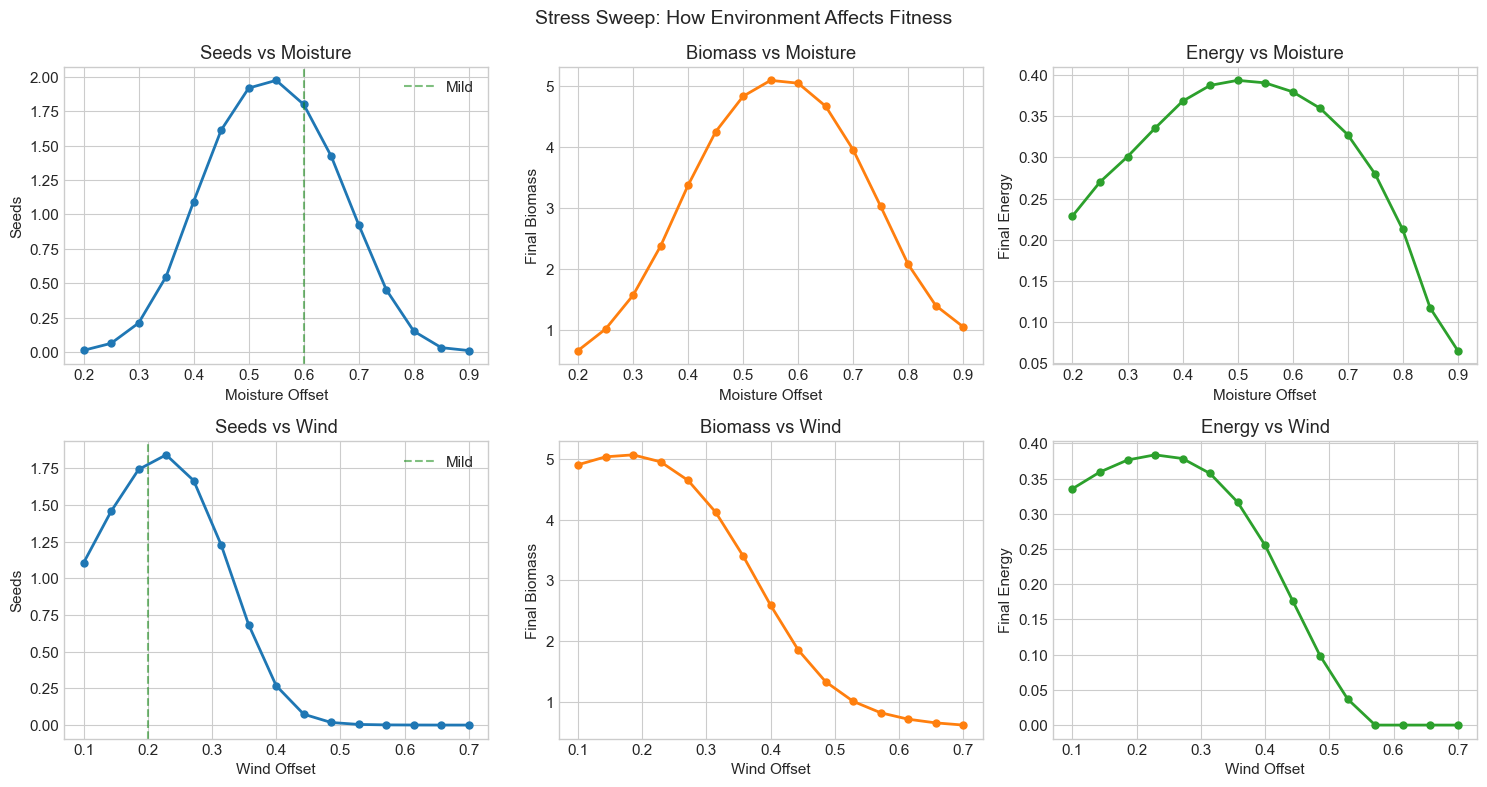

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Moisture sweep - top row
axes[0, 0].plot(moisture_results['moisture'], moisture_results['seeds'], 'o-', linewidth=2, markersize=5)
axes[0, 0].set_xlabel('Moisture Offset')
axes[0, 0].set_ylabel('Seeds')
axes[0, 0].set_title('Seeds vs Moisture')
axes[0, 0].axvline(x=0.6, color='green', linestyle='--', alpha=0.5, label='Mild')
axes[0, 0].legend()

axes[0, 1].plot(moisture_results['moisture'], moisture_results['biomass'], 'o-', linewidth=2, markersize=5, color='tab:orange')
axes[0, 1].set_xlabel('Moisture Offset')
axes[0, 1].set_ylabel('Final Biomass')
axes[0, 1].set_title('Biomass vs Moisture')

axes[0, 2].plot(moisture_results['moisture'], moisture_results['energy'], 'o-', linewidth=2, markersize=5, color='tab:green')
axes[0, 2].set_xlabel('Moisture Offset')
axes[0, 2].set_ylabel('Final Energy')
axes[0, 2].set_title('Energy vs Moisture')

# Wind sweep - bottom row
axes[1, 0].plot(wind_results['wind'], wind_results['seeds'], 'o-', linewidth=2, markersize=5)
axes[1, 0].set_xlabel('Wind Offset')
axes[1, 0].set_ylabel('Seeds')
axes[1, 0].set_title('Seeds vs Wind')
axes[1, 0].axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Mild')
axes[1, 0].legend()

axes[1, 1].plot(wind_results['wind'], wind_results['biomass'], 'o-', linewidth=2, markersize=5, color='tab:orange')
axes[1, 1].set_xlabel('Wind Offset')
axes[1, 1].set_ylabel('Final Biomass')
axes[1, 1].set_title('Biomass vs Wind')

axes[1, 2].plot(wind_results['wind'], wind_results['energy'], 'o-', linewidth=2, markersize=5, color='tab:green')
axes[1, 2].set_xlabel('Wind Offset')
axes[1, 2].set_ylabel('Final Energy')
axes[1, 2].set_title('Energy vs Wind')

plt.suptitle('Stress Sweep: How Environment Affects Fitness', fontsize=14)
plt.tight_layout()
plt.show()

### Gradient Landscape Interpretation

The stress sweep reveals the "fitness landscape" for our simulation:

**Moisture Effects:**
- Low moisture (drought) severely limits photosynthesis via Michaelis-Menten saturation
- There's a "cliff" below ~0.4 where trees can barely survive
- High moisture allows normal growth and seed production
- The gradient is steepest in the 0.4-0.6 range - optimal for learning

**Wind Effects:**  
- Wind directly damages leaves, reducing photosynthetic capacity
- The damage cap (5%/day) prevents instant death but creates sustained pressure
- Trunk investment becomes critical - more trunk = less vulnerability
- The gradient exists throughout, making wind a good "teacher" for trunk investment

**Implications for Optimization:**
- Policies can be optimized via gradient descent in mild/moderate climates
- Extreme climates have flat/near-zero gradients (no learning signal)
- The flower gating ensures flowering only happens after proper development
- Investment gating prevents suicide at low energy levels

Running 2D sweep (100 simulations)...
Done!


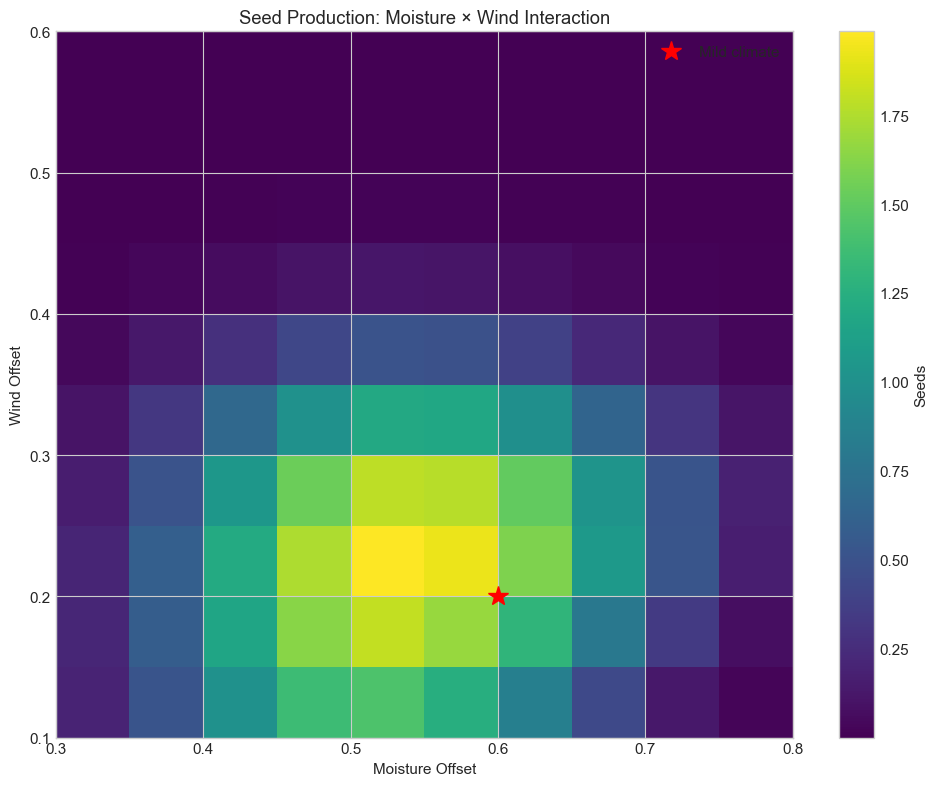

In [15]:
# 2D Sweep: Moisture x Wind
moisture_grid = np.linspace(0.3, 0.8, 10)
wind_grid = np.linspace(0.1, 0.6, 10)

seed_heatmap = np.zeros((len(wind_grid), len(moisture_grid)))
base = ClimateConfig.mild()

print("Running 2D sweep (100 simulations)...")
for i, w_off in enumerate(wind_grid):
    for j, m_off in enumerate(moisture_grid):
        climate = ClimateConfig(
            light=base.light,
            moisture=StressParams(offset=m_off, amplitude=0.15, frequency=0.08, phase=1.0),
            wind=StressParams(offset=w_off, amplitude=0.1, frequency=0.15, phase=0.5),
        )
        traj = run_season(config, climate, policies.baseline_policy)
        seed_heatmap[i, j] = float(traj.seeds)
print("Done!")

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(seed_heatmap, origin='lower', aspect='auto', cmap='viridis',
               extent=[moisture_grid[0], moisture_grid[-1], wind_grid[0], wind_grid[-1]])
ax.set_xlabel('Moisture Offset')
ax.set_ylabel('Wind Offset')
ax.set_title('Seed Production: Moisture × Wind Interaction')
plt.colorbar(im, ax=ax, label='Seeds')

# Mark the mild climate point
ax.plot(0.6, 0.2, 'r*', markersize=15, label='Mild climate')
ax.legend()

plt.tight_layout()
plt.show()

## 9. Final Summary

This notebook has demonstrated the complete Arborhedron simulation framework:

### Core Mechanics
- **8-compartment tree state**: energy, water, nutrients, roots, trunk, shoots, leaves, flowers
- **Michaelis-Menten surrogates**: realistic saturation dynamics for all biological processes
- **Environmental stress**: sinusoidal light, moisture, and wind signals
- **Resource allocation**: softmax-based policies that sum to 1

### Stabilization Mechanisms
1. **Self-shading (Beer-Lambert)**: prevents runaway leaf growth
2. **Resource consumption**: water/nutrients consumed during photosynthesis and growth
3. **Transport bottleneck**: trunk limits water delivery to canopy
4. **Investment gating**: reduces investment when energy is low (prevents suicide)
5. **Flower gating**: requires maturity and trunk support before flowering
6. **Wind damage cap**: prevents instant death from sustained wind

### Fitness Landscape
- Mild climates produce gradient signal for optimization
- Harsh climates (low moisture, high wind) create "dead zones" with flat gradients
- The 2D heatmap reveals the optimal operating region for policy learning

### Next Steps
1. **Gradient descent optimization**: Learn allocation policies via autodiff
2. **Neural policy networks**: Replace hand-coded rules with learned parameters
3. **3D visualization**: Render tree growth morphology over time
4. **Multi-climate training**: Policies that generalize across environments